# Оценка линейного искажающего оператора в задаче восстановления изображений
Время работы: очень долго(больше часа)

In [1]:
import numpy as np
from skimage import color, data, restoration, img_as_float, io
# import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv2
from skimage.measure import compare_psnr
from functools import partial
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm_notebook

from util import *
from richardson_lucy import *
plt.gray()

In [2]:
astro = color.rgb2gray(data.astronaut())
liftingbody = img_as_float(io.imread('liftingbody.png'))

In [3]:
iterations=20

## Оценка криволинейного оператора смаза, представленного кривой Безье

[15, 4, 20, 20]


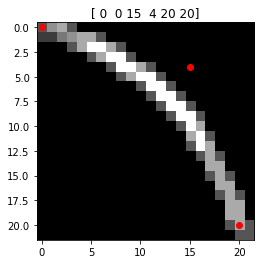

In [4]:
sz = 21
deg = 5
points_real = [(deg-1)*sz//deg-1, sz//deg, sz-1, sz-1]
print(points_real)
psf_bezier = bezier_psf2(points_real, 100)
plt.imshow(psf_bezier)
plt.title(np.concatenate(([0,0], points_real)))
plt.plot(0, 0, 'ro')
plt.plot(points_real[0], points_real[1], 'ro')
plt.plot(points_real[2], points_real[3], 'ro')
plt.savefig("pic/curved-psf.png")
plt.show()

In [5]:
lifting_bezier_blurred = convolve2d(liftingbody, psf_bezier, 'same')
#lifting_bezier_blurred = edgetaper(lifting_bezier_blurred, gkern2(41,10))

In [6]:
lifting_restored = restoration.richardson_lucy(lifting_bezier_blurred, psf_bezier, iterations=iterations)
psnr_py = compare_psnr_crop(liftingbody, lifting_restored)

deconv_bezier = richardson_lucy_matlab(lifting_bezier_blurred, psf_bezier, iterations=iterations, clip=True, useFFT=True, dampar=0.004)
psnr_my = compare_psnr_crop(liftingbody, deconv_bezier['image'])

/home/progiv/study/diploma/scikit-image/skimage/restoration/deconvolution.py:389: RuntimeWarning: invalid value encountered in true_divide
  relative_blur = image / convolve_method(im_deconv, psf, 'same')
/home/progiv/study/diploma/scikit-image/skimage/restoration/deconvolution.py:393: RuntimeWarning: invalid value encountered in greater
  im_deconv[im_deconv > 1] = 1
/home/progiv/study/diploma/scikit-image/skimage/restoration/deconvolution.py:394: RuntimeWarning: invalid value encountered in less
  im_deconv[im_deconv < -1] = -1


/home/progiv/.local/lib/python3.6/site-packages/matplotlib/colors.py:897: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/progiv/.local/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


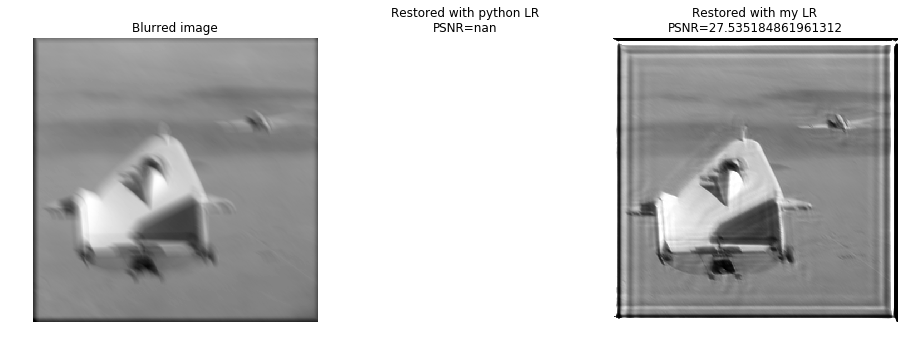

In [7]:
show_results(lifting_bezier_blurred, lifting_restored, deconv_bezier['image'],
            titles=['Blurred image', 'Restored with python LR\nPSNR={0}'.format(psnr_py), 'Restored with my LR\nPSNR={0}'.format(psnr_my)])

### Кепстр

In [8]:
s_n, S_find = find_noise(lifting_bezier_blurred)
print(s_n, S_find)

7.267261165382173e-05 3.921113183461706e-07


In [9]:
#N,M = lifting_bezier_blurred.shape
# ( ifft2 (100* log (1+ abs ( fft2 ( I ) ) ) ) ) ;
K = np.real(np.fft.ifftn(100*np.log(1+np.abs(np.fft.fftn(lifting_bezier_blurred)))))
#K_shift = K
K_shift = np.fft.fftshift(K)

In [10]:
c,r = np.unravel_index(np.argmin(K_shift, axis=None), K_shift.shape)
nn = np.argmin(np.real(K_shift))
n, m, = K_shift.shape
x2 = np.array([r - n//2, c - m//2])
if x2[0]<0:
    x2 = -x2
x1 = x2/2 + np.array([2,-2])
print(x2)

[20 21]


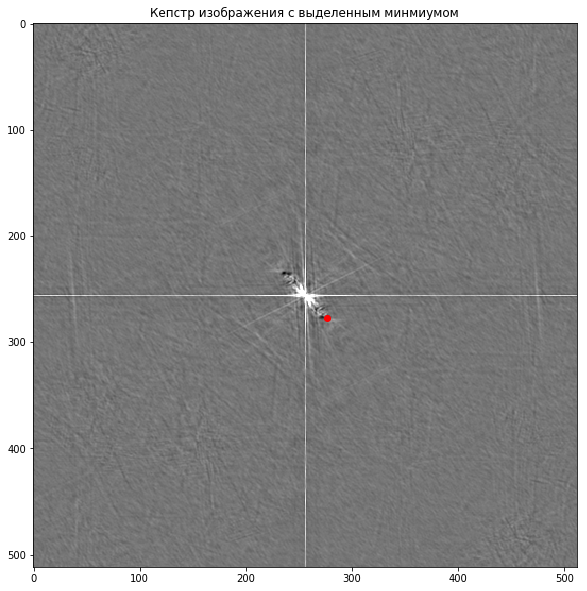

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(np.clip(np.real(K_shift),-1,1))#, vmin=noisy.min(), vmax=noisy.max())
plt.plot(m//2 + x2[0], n//2 + x2[1], 'ro')
plt.title('Кепстр изображения с выделенным минмиумом')
plt.savefig('pic/kepstr.png')
plt.show()

In [12]:
x0 = np.concatenate((x1, x2))
print(x0)

[12.   8.5 20.  21. ]


### Минимизация

In [13]:
def funcToMinimizeCurved(xy, I_blurred, crop=100, *args, **kwargs):
    print(xy)
    psf = bezier_psf2(xy, n=100)
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = fftconvolve(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))
#partial(funcToMinimizeCurved, I_blurred=lifting_bezier_blurred, iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True)([0, 10, 10, 10])

In [14]:
def funcToMinimizeCurved2(xy, I_blurred, xy2, crop=100, *args, **kwargs):
    psf = bezier_psf2(np.concatenate((np.array(xy), np.array(xy2))))
    restored = richardson_lucy_matlab(I_blurred, psf, *args, **kwargs)
    I_restored = restored['image']
    df = convolve2d(I_restored, psf, 'same') - I_blurred
    return np.mean(np.square(df[crop:-crop, crop:-crop]))

In [15]:
f = partial(funcToMinimizeCurved2, I_blurred=lifting_bezier_blurred, xy2=x2, iterations=iterations, eps=1e-5, dampar=10*s_n, clip=True, useFFT=True)

<img src='optimization_useless.png'> <img src='optimization_useless_x2.png'>

In [ ]:
scale = 4
a = np.ones((scale*x2[1], scale*x2[0]))
for yy in tqdm_notebook(range(scale*x2[1])):
    for xx in range(scale*x2[0]):
        val = f(np.array([xx/scale,yy/scale]))
        print(yy/scale, xx/scale, val)
        a[yy,xx] = val

HBox(children=(IntProgress(value=0, max=84), HTML(value='')))

0.0 0.0 5.3903175223358916e-05
0.0 0.25 5.8727041786189575e-05
0.0 0.5 4.945895541648942e-05
0.0 0.75 4.490313007278311e-05
0.0 1.0 5.7643292277156914e-05
0.0 1.25 6.093653821640951e-05
0.0 1.5 5.761942242275114e-05
0.0 1.75 5.503541943345913e-05
0.0 2.0 5.225163434769573e-05
0.0 2.25 5.675180330248666e-05
0.0 2.5 5.675641224381217e-05
0.0 2.75 5.993797641357264e-05
0.0 3.0 3.686430373916708e-05
0.0 3.25 4.338605020336007e-05
0.0 3.5 5.627060929745253e-05
0.0 3.75 4.794440220496916e-05
0.0 4.0 5.26713462100486e-05
0.0 4.25 5.334948866169413e-05
0.0 4.5 5.276294899993061e-05
0.0 4.75 5.40900947673977e-05
0.0 5.0 5.1934752114511006e-05
0.0 5.25 4.918476579353033e-05
0.0 5.5 4.8624866573849104e-05
0.0 5.75 4.5318657514081154e-05
0.0 6.0 4.191499789785409e-05
0.0 6.25 4.5360653687989995e-05
0.0 6.5 5.138913337156558e-05
0.0 6.75 4.8656505547653805e-05
0.0 7.0 3.675688629843306e-05
0.0 7.25 4.0614670626484494e-05
0.0 7.5 3.918928885190868e-05
0.0 7.75 3.362610043923057e-05
0.0 8.0 3.0623558

0.75 4.75 4.3352928748992515e-05
0.75 5.0 5.510209651367213e-05
0.75 5.25 5.477043257992862e-05
0.75 5.5 4.674740575514998e-05
0.75 5.75 4.688219658277459e-05
0.75 6.0 4.841760047725089e-05
0.75 6.25 4.075476638390859e-05
0.75 6.5 3.851309617438809e-05
0.75 6.75 3.688174344571994e-05
0.75 7.0 4.30115721924838e-05
0.75 7.25 4.670307882257326e-05
0.75 7.5 4.5409742039136325e-05
0.75 7.75 4.1337473481564334e-05
0.75 8.0 4.7221858995344216e-05
0.75 8.25 4.1244810708123334e-05
0.75 8.5 3.501648955420085e-05
0.75 8.75 3.501648955420085e-05
0.75 9.0 3.332840105425085e-05
0.75 9.25 4.1479945278965e-05
0.75 9.5 4.0533466699405683e-05
0.75 9.75 4.165569539882202e-05
0.75 10.0 3.4493224362683336e-05
0.75 10.25 2.220265372865592e-05
0.75 10.5 2.494874361178886e-05
0.75 10.75 2.3174352778678847e-05
0.75 11.0 2.367746254687615e-05
0.75 11.25 3.369456535918463e-05
0.75 11.5 2.6926273514800702e-05
0.75 11.75 2.9556849221982943e-05
0.75 12.0 3.3630064284230955e-05
0.75 12.25 2.3165339908042616e-05
0.75

1.5 9.0 3.2242198340012065e-05
1.5 9.25 3.0935513201344676e-05
1.5 9.5 3.481100444152637e-05
1.5 9.75 3.373736766836094e-05
1.5 10.0 4.6044087070578566e-05
1.5 10.25 2.7576042808218882e-05
1.5 10.5 2.4507947664185952e-05
1.5 10.75 2.6801900751894235e-05
1.5 11.0 2.39980241664141e-05
1.5 11.25 2.2741811289987377e-05
1.5 11.5 1.9284761479387094e-05
1.5 11.75 2.1867414491826443e-05
1.5 12.0 3.81525065318224e-05
1.5 12.25 3.4960899380512926e-05
1.5 12.5 3.12234965912683e-05
1.5 12.75 2.0015223391166975e-05
1.5 13.0 2.0848933382415108e-05
1.5 13.25 2.115864641657636e-05
1.5 13.5 2.314608367986193e-05
1.5 13.75 1.997338459873349e-05
1.5 14.0 3.0180143157925214e-05
1.5 14.25 2.417995851979261e-05
1.5 14.5 1.948637176023215e-05
1.5 14.75 1.7766953187789054e-05
1.5 15.0 1.8130231851770436e-05
1.5 15.25 2.1490417704015147e-05
1.5 15.5 1.8267453591408415e-05
1.5 15.75 1.6958579810718046e-05
1.5 16.0 1.739585134581504e-05
1.5 16.25 1.9792295985730388e-05
1.5 16.5 2.135189189131437e-05
1.5 16.75 1.

In [ ]:
c,r = np.unravel_index(np.argmin(a, axis=None), a.shape)

In [ ]:
plt.figure(figsize=(6,6))
fig = plt.imshow(a, 'gray')
plt.title('Cost function value for second point coordinates,\ndarker is better')
plt.plot(points_real[0]*scale, points_real[1]*scale, 'ro')
plt.plot(r,c,'go')
plt.legend(['real','min'], loc='lower right')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.savefig('pic/optimization_useless_x{0}.png'.format(scale))
plt.show()

In [ ]:
points_found = np.concatenate(([r/scale,c/scale], x2))#[(deg-1)*sz//deg-1, sz//deg, sz-1, sz-1]
print(points_found)
psf_found = bezier_psf2(points_found)

In [ ]:
f([r/scale,c/scale]), f(points_real[:2])

In [ ]:
#%matplotlib notebook
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
X, Y = np.meshgrid(range(a.shape[1]),range(a.shape[0]))

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, a)
plt.show()

In [ ]:
deconv_orig = richardson_lucy_matlab(lifting_bezier_blurred, psf_bezier, iterations=iterations, dampar=s_n, useFFT=False)
psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

psf_init = bezier_psf2(x0)
deconv_init = richardson_lucy_matlab(lifting_bezier_blurred, psf_init, iterations=iterations, dampar=s_n, useFFT=False)
psnr_init = compare_psnr_crop(liftingbody, deconv_init['image'])

#points_found = res_tnc['x']
#psf_found = bezier_psf2(points_found)
deconv_found = richardson_lucy_matlab(lifting_bezier_blurred, psf_found, iterations=iterations, dampar=s_n, useFFT=False)
psnr_found = compare_psnr_crop(liftingbody, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord={1}'.format(psnr_orig.round(2), points_real), 
                     'With initial approxiamtion\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), x0),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), points_found)],
            savefig="pic/curved-grid.png")

In [ ]:
#x0 = [12, 10, 20, 20]
res_nelder = minimize(partial(funcToMinimizeCurved2, I_blurred=lifting_bezier_blurred, xy2=x2, iterations=iterations, eps=1e-5, dampar=s_n, useFFT=True),
                      x0=x1, method='Nelder-Mead', options={'xtol': 1e-3, 'disp': True})
print(res_nelder)

In [ ]:
x1, points_real

In [ ]:
deconv_orig = richardson_lucy_matlab(lifting_bezier_blurred, psf_bezier, iterations=iterations, dampar=s_n, useFFT=False)
psnr_orig = compare_psnr_crop(liftingbody, deconv_orig['image'])

psf_init = bezier_psf2(x0)
deconv_init = richardson_lucy_matlab(lifting_bezier_blurred, psf_init, iterations=iterations, dampar=s_n, useFFT=False)
psnr_init = compare_psnr_crop(liftingbody, deconv_init['image'])

points_found = res_nelder['x']
psf_found = bezier_psf2(points_found)
deconv_found = richardson_lucy_matlab(lifting_bezier_blurred, psf_found, iterations=iterations, dampar=s_n, useFFT=False)
psnr_found = compare_psnr_crop(liftingbody, deconv_found['image'])

show_results(deconv_orig['image'], deconv_init['image'], deconv_found['image'],
             titles=['Restored with true psf\nPSNR={0}\ncoord={1}'.format(psnr_orig.round(2), points_real), 
                     'With initial approxiamtion\nPSNR={0}\ncoord={1}'.format(psnr_init.round(2), x0),
                     'Minimized error\nPSNR={0}\ncoord={1}'.format(psnr_found.round(2), res_nelder['x'])])

* Запустить градиентный метод
* Сделать мощный edgetaper
* Сделать антиалиасинг psf